# Abstract
This notebook is a simple comparison of OpenAI vs SBERT embeddings. I'm using a small subset of ["The Pile"](https://pile.eleuther.ai/), which is a diverse open-source language modeling dataset.  
### The expectation
1. We expect that texts that are from the same document should have similarity in their embeddings while texts that are not should have low similarity. We test for this by chunking up documents from different slices of The Pile, and compare their self-similarity vs cross-similarity.
2. If we collect a dataset of embeddings from across a diverse set of texts, we intuitively expect the embedding to make use of most of the k-dimensional space. Truly testing for this is hard, due to the curse of dimensionality, but we can at least look at each dimension in isolation and see whether there's reasonable variance within that dimension among our set. 
### The results
1. OpenAI embeddings of very different types of text are only somewhat less similar to one another, compared to the similarity of texts that are from the same document. SBERT's embeddings do not have this problem. 
2. Compared to SBERT's embeddings, the variance of each dimension in OpenAI's embeddings is much smaller; meaning that no matter what the input text is, the value assigned to most dimensions is in a narrow range. 

# Imports

In [82]:
from datasets import load_dataset
from itertools import islice
import numpy as np
import pandas as pd
import random
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
import os
from sentence_transformers import SentenceTransformer, util

# Load subset of Pile dataset

In [3]:
p10k = load_dataset("NeelNanda/pile-10k", split="train")

Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (/Users/venu/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [4]:
p10k[0, 1].keys()

dict_keys(['text', 'meta'])

In [5]:
p10k[0, 0]["meta"][0]

{'pile_set_name': 'Pile-CC'}

In [6]:
p10k[80, 0]["meta"][0]['pile_set_name']

'StackExchange'

In [7]:
# get pile_set_name for each example, and count frequencies of each pile_set_name
names = [p10k[i, 0]["meta"][0]['pile_set_name'] for i in range(len(p10k))]
from collections import Counter
Counter(names)


Counter({'Pile-CC': 2524,
         'Github': 855,
         'OpenWebText2': 1520,
         'StackExchange': 1399,
         'Wikipedia (en)': 779,
         'PubMed Abstracts': 1423,
         'USPTO Backgrounds': 514,
         'FreeLaw': 241,
         'PubMed Central': 259,
         'Enron Emails': 47,
         'HackerNews': 81,
         'NIH ExPorter': 104,
         'Books3': 9,
         'ArXiv': 91,
         'DM Mathematics': 99,
         'OpenSubtitles': 27,
         'BookCorpus2': 2,
         'Ubuntu IRC': 2,
         'YoutubeSubtitles': 11,
         'EuroParl': 6,
         'PhilPapers': 5,
         'Gutenberg (PG-19)': 2})

In [8]:
# make a dictionary with pile_set_name as key, and randomly include upto 'k' examples from each pile_set_name
samples = {}
num_chunks = 10
chunk_size = 1000
for i in range(len(p10k)):
    name = p10k[i, 0]["meta"][0]['pile_set_name']
    text = p10k[i, 0]["text"][0]
    if name not in samples and len(text) > chunk_size * num_chunks:
        # chunk up text into chunks of chunk_size characters each
        chunks = [text[i:i+chunk_size] for i in range(0, chunk_size*num_chunks, chunk_size)]
        samples[name] = chunks


In [9]:
samples.keys()

dict_keys(['Pile-CC', 'USPTO Backgrounds', 'FreeLaw', 'PubMed Central', 'StackExchange', 'Books3', 'OpenWebText2', 'ArXiv', 'Github', 'OpenSubtitles', 'Wikipedia (en)', 'BookCorpus2', 'HackerNews', 'Ubuntu IRC', 'YoutubeSubtitles', 'PhilPapers', 'Gutenberg (PG-19)', 'EuroParl'])

In [113]:
len(samples.items())
for k, v in islice(samples.items(), 1):
    print(k, len(v), v[0])

Pile-CC 10 It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.

There’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.

Concept

Working over the theme was probably one of the hardest tasks I had to face.

Originally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.

In the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge. But is i

# Get OpenAI embeddings of each of the chunks

In [11]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [73]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002

In [74]:
cosine_similarity(get_embedding(samples["Pile-CC"][0], engine=embedding_model), get_embedding(samples["Pile-CC"][1], engine=embedding_model))

0.8459940907245606

In [75]:
len(get_embedding(samples["Pile-CC"][0], engine=embedding_model))

1536

In [76]:
cosine_similarity(get_embedding(samples["Pile-CC"][0], engine=embedding_model), get_embedding(samples["FreeLaw"][0], engine=embedding_model))

0.6870388985092611

In [77]:
openai_embs = {}
for k1, v1 in samples.items():
    openai_embs[k1] = [get_embedding(v1[i], engine=embedding_model) for i in range(len(v1))]


In [78]:
# pandas dataframe with row and column labels and cosine similarity values
num_classes = 6
selected_samples = dict(islice(samples.items(), num_classes))
df = pd.DataFrame(columns=selected_samples.keys(), index=selected_samples.keys())
random.seed(42)
for k1, v1 in selected_samples.items():
    for k2, v2 in selected_samples.items():
        # get average of 10 cosine similarity values
        sum = 0
        l = 10
        for i in range(l):
            rnd1 = random.randint(0, len(v1)-1)
            rnd2 = random.randint(0, len(v2)-1)
            sum += cosine_similarity(openai_embs[k1][rnd1], openai_embs[k2][rnd2])
        df.loc[k1][k2] = float(sum / l)
df = df.apply(pd.to_numeric, errors='coerce') # not sure why I'm needing this, but otherwise it's inferring the type as object

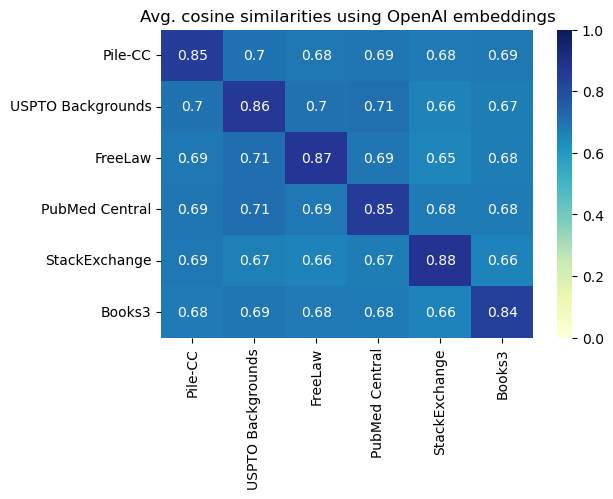

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # increase figure size for better visibility
sns.heatmap(df, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Avg. cosine similarities using OpenAI embeddings')
plt.show()


# Get SBERT embeddings of each of the chunks

In [48]:

model = SentenceTransformer('all-MiniLM-L6-v2')


In [49]:
util.cos_sim(model.encode(samples["Pile-CC"][0]), model.encode(samples["Pile-CC"][1]))

tensor([[0.6097]])

In [50]:
util.cos_sim(model.encode(samples["Pile-CC"][0]), model.encode(samples["FreeLaw"][0]))

tensor([[0.0098]])

In [51]:
sbert_embs = {}
for k1, v1 in samples.items():
    sbert_embs[k1] = [model.encode(v1[i]) for i in range(len(v1))]


In [54]:
# pandas dataframe with row and column labels and cosine similarity values
from itertools import islice
import pandas as pd
import random
num_classes = 6
selected_samples = dict(islice(samples.items(), num_classes))
sbert_sims = pd.DataFrame(columns=selected_samples.keys(), index=selected_samples.keys())
random.seed(42)
for k1, v1 in selected_samples.items():
    for k2, v2 in selected_samples.items():
        # get average of 10 cosine similarity values
        sum = 0
        l = 10
        for i in range(l):
            rnd1 = random.randint(0, len(v1)-1)
            rnd2 = random.randint(0, len(v2)-1)
            sum += util.cos_sim(sbert_embs[k1][rnd1], sbert_embs[k2][rnd2])
        sbert_sims.loc[k1][k2] = float(sum / l)
# not sure why I'm needing this, but otherwise it's inferring the type as object
sbert_sims = sbert_sims.apply(pd.to_numeric, errors='coerce') 

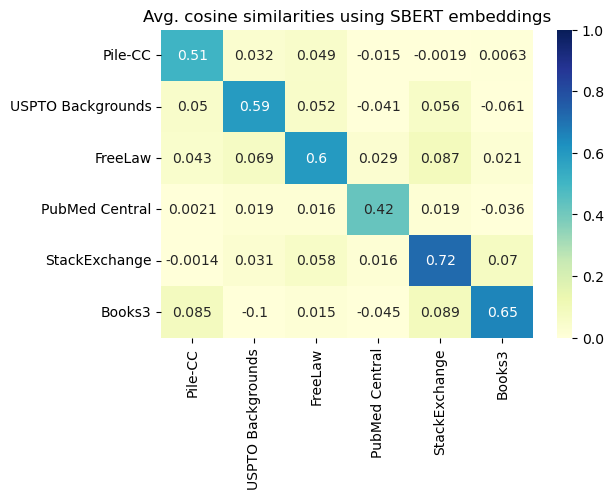

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # increase figure size for better visibility
sns.heatmap(sbert_sims, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Avg. cosine similarities using SBERT embeddings')
plt.show()


# Compare the dimensions of OpenAI's vs SBERT's embeddings
One hypothesis I can think of is that there are some useless dimensions, i.e. there is very little variation in those dimensions across 
different sentences. 

In [80]:
len(openai_embs["ArXiv"][0])

1536

In [81]:
len(sbert_embs["ArXiv"][0])

384

In [84]:
# convert openai_embs, which is currently a dictionary, to a matrix
openai_embs_matrix = np.zeros((len(openai_embs)*len(openai_embs["ArXiv"]), len(openai_embs["ArXiv"][0])))

In [93]:
sbert_embs_matrix = np.zeros((len(sbert_embs)*len(sbert_embs["ArXiv"]), len(sbert_embs["ArXiv"][0])))

In [99]:
for i, (k, v) in enumerate(openai_embs.items()):
    for j in range(len(v)):
        openai_embs_matrix[i*len(v)+j] = openai_embs[k][j]
        sbert_embs_matrix[i*len(v)+j] = sbert_embs[k][j]

In [104]:
print(np.sum(openai_embs_matrix[0] - openai_embs["Pile-CC"][0]))
print(np.sum(sbert_embs_matrix[0] - sbert_embs["Pile-CC"][0]))

0.0
0.0


In [106]:
print(np.count_nonzero(openai_embs_matrix) - np.shape(openai_embs_matrix)[0] * np.shape(openai_embs_matrix)[1])
print(np.count_nonzero(sbert_embs_matrix) - np.shape(sbert_embs_matrix)[0] * np.shape(sbert_embs_matrix)[1])

0
0


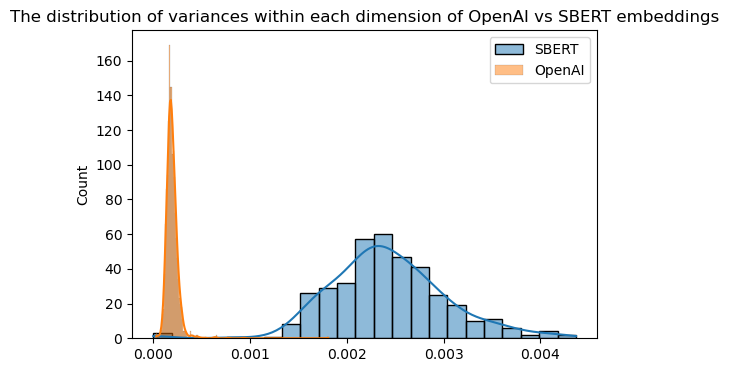

In [112]:
# let's get variance along each column of openai_embs_matrix
openai_variances = np.var(openai_embs_matrix, axis=0)
sbert_variances = np.var(sbert_embs_matrix, axis=0)
# let's plot the distribution of variances in the same plot
plt.figure(figsize=(6, 4))  # increase figure size for better visibility
sns.histplot(sbert_variances, kde=True, label='SBERT')
sns.histplot(openai_variances, kde=True, label='OpenAI')
plt.legend()
plt.title('The distribution of variances within each dimension of OpenAI vs SBERT embeddings')
plt.show()